In [ ]:
# Final Project
# Author: Duoduo Yao
# NetID: dy116

In [ ]:
'''
Part 1:
You own the 3 portfolios in the file “initial_portfolio.csv.” The risk free rate is in “rf.csv. ” Daily prices of the stocks are in “DailyPrices.csv.”
You bought these portfolios at the end of 2023. Model the returns of stocks using CAPM with SPY as the market. Use the data up to the end of 2023 for the regression.
Your holding period on these portfolios is to the end of the price data.
Use you the fitted models to attribute the realized risk and return for each portfolio and the total portfolio for the holding period. Split the attribution between the systematic and idiosyncratic components. You should calculate the idiosyncratic contribution for each stock, but present the total in your output.
Discuss the results.
'''

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

In [78]:
# Step 1: Load the data
daily_prices = pd.read_csv('../Projects/Final Project/DailyPrices.csv')
initial_portfolio = pd.read_csv('../Projects/Final Project/initial_portfolio.csv')
risk_free = pd.read_csv('../Projects/Final Project/rf.csv')

# Convert dates to datetime format
daily_prices['Date'] = pd.to_datetime(daily_prices['Date'])
risk_free['Date'] = pd.to_datetime(risk_free['Date'])

# Step 2: Split data into training (up to 2023-12-29) and testing (from 2023-12-29 onward) periods
training_data = daily_prices[daily_prices['Date'] <= pd.Timestamp('2023-12-29')]
testing_data = daily_prices[daily_prices['Date'] >= pd.Timestamp('2023-12-29')]

print(training_data.head())
print(testing_data.head())

        Date         SPY        AAPL       NVDA        MSFT       AMZN  \
0 2023-01-03  370.367920  123.768456  14.304595  236.183502  85.820000   
1 2023-01-04  373.227142  125.045052  14.738281  225.852097  85.139999   
2 2023-01-05  368.967438  123.718987  14.254632  219.158371  83.120003   
3 2023-01-06  377.428589  128.271118  14.848200  221.741211  86.080002   
4 2023-01-09  377.214661  128.795578  15.616640  223.900162  87.360001   

         META      GOOGL       AVGO        TSLA  ...        SBUX         MMC  \
0  124.265305  88.798103  53.397118  108.099998  ...   96.842888  161.264664   
1  126.885315  87.761856  54.049290  113.639999  ...  100.329346  164.402908   
2  126.456940  85.888649  53.545685  110.339996  ...  100.300537  161.420135   
3  129.525223  87.024529  56.768929  113.059998  ...  102.471153  166.103210   
4  128.977310  87.702065  55.655602  119.769997  ...  100.598274  165.549393   

         MDT          CB         LMT        KKR         MU         PLD  \


In [93]:
# Step 3: Calculate returns
# Function to calculate daily returns
def calculate_returns(prices_df):
    returns_df = prices_df.copy()
    for column in prices_df.columns:
        if column != 'Date':
            returns_df[column] = prices_df[column].pct_change()
    return returns_df.dropna()

# Calculate returns for training and testing periods
training_returns = calculate_returns(training_data)
testing_returns = calculate_returns(testing_data)

import warnings
# Step 4: Merge risk-free rate with returns data
# Use first training return date to filter risk-free data to align dates properly
first_return_date = training_returns['Date'].min()
risk_free_filtered = risk_free[risk_free['Date'] >= first_return_date].copy()

# Check for duplicate dates in risk_free data that could cause the error
duplicate_dates = risk_free_filtered['Date'].duplicated().sum()
if duplicate_dates > 0:
    print(f"Warning: Found {duplicate_dates} duplicate dates in risk_free data. Keeping only the first occurrence.")
    risk_free_filtered = risk_free_filtered.drop_duplicates(subset=['Date'], keep='first')

# Merge risk-free rates with returns
training_returns = pd.merge(training_returns, risk_free_filtered, on='Date', how='left')
testing_returns = pd.merge(testing_returns, risk_free_filtered, on='Date', how='left')

# Fill any missing risk-free values
if training_returns['rf'].isna().any() or testing_returns['rf'].isna().any():
    print("Warning: Some risk-free rates are missing. Using forward fill method.")
    training_returns['rf'] = training_returns['rf'].ffill()
    testing_returns['rf'] = testing_returns['rf'].ffill()

with warnings.catch_warnings():
    warnings.simplefilter("ignore", category=pd.errors.PerformanceWarning)
    # Calculate excess returns more efficiently (avoiding fragmentation)
    # Create new dataframes to hold the excess returns
    training_returns_with_excess = training_returns.copy()
    testing_returns_with_excess = testing_returns.copy()

    # Calculate excess returns for all columns at once
    excess_columns = {}
    for column in training_returns.columns:
        if column not in ['Date', 'rf']:
            excess_columns[f'{column}_excess'] = training_returns[column] - training_returns['rf']

    # Add all new columns at once to avoid fragmentation
    for col_name, col_data in excess_columns.items():
        training_returns_with_excess[col_name] = col_data

    # Do the same for testing data
    excess_columns = {}
    for column in testing_returns.columns:
        if column not in ['Date', 'rf']:
            excess_columns[f'{column}_excess'] = testing_returns[column] - testing_returns['rf']

    for col_name, col_data in excess_columns.items():
        testing_returns_with_excess[col_name] = col_data

# Replace the original dataframes
training_returns = training_returns_with_excess
testing_returns = testing_returns_with_excess

# # Verify calculations
# print(f"First few rows of training excess returns for SPY:")
# print(training_returns[['Date', 'SPY', 'rf', 'SPY_excess']].head())
# print(training_returns[['Date', 'AAPL', 'rf', 'AAPL_excess']].head())
# print(training_returns[['Date', 'rf']])
# print(training_data)

In [98]:
# Step 5: Fit CAPM models using training data (2023)
market_symbol = 'SPY'
symbols = [col for col in daily_prices.columns if col != 'Date']

# Store CAPM parameters
capm_params = {}

for symbol in symbols:
    if symbol == market_symbol:
        continue

    # Linear regression for each stock against the market
    X = training_returns[f'{market_symbol}_excess'].values
    Y = training_returns[f'{symbol}_excess'].values

    # Remove NaN values
    mask = ~np.isnan(X) & ~np.isnan(Y)
    X = X[mask]
    Y = Y[mask]

    if len(X) < 30:  # Skip if insufficient data
        print(f"Insufficient data for {symbol}")
        continue

    # Fit linear regression: excess_return = alpha + beta * market_excess_return
    slope, intercept, r_value, p_value, std_err = stats.linregress(X, Y)

    # Store parameters
    capm_params[symbol] = {
        'alpha': intercept,
        'beta': slope,
        'r_squared': r_value**2,
        'p_value': p_value,
        'std_err': std_err
    }


# print(capm_params['TSLA'])


{'alpha': np.float64(0.0019547817656119454), 'beta': np.float64(2.2098089354936556), 'r_squared': np.float64(0.30344596175696464), 'p_value': np.float64(3.673793898095448e-21), 'std_err': np.float64(0.213031082764571)}


In [116]:
# Step 6: Calculate portfolio composition and value
portfolio_symbols = initial_portfolio['Symbol'].unique()
portfolio_weights = {}

# Get unique portfolios
portfolios = initial_portfolio['Portfolio'].unique()

# Calculate initial investment for each portfolio
portfolio_values = {}
for portfolio in portfolios:
    portfolio_df = initial_portfolio[initial_portfolio['Portfolio'] == portfolio]
    portfolio_total_value = 0

    for _, row in portfolio_df.iterrows():
        symbol = row['Symbol']
        holdings = row['Holding']

        # Get the price at the end of 2023 (last training day)
        last_training_date = training_data['Date'].max()
        price = training_data[training_data['Date'] == last_training_date][symbol].values[0]
        # print(symbol, price)

        value = holdings * price
        portfolio_total_value += value

    portfolio_values[portfolio] = portfolio_total_value
    # print(f"Portfolio values for {portfolio}: {portfolio_total_value}")

# Calculate portfolio weights
portfolio_weights = {}
for portfolio in portfolios:
    portfolio_df = initial_portfolio[initial_portfolio['Portfolio'] == portfolio]
    weights = {}

    for _, row in portfolio_df.iterrows():
        symbol = row['Symbol']
        holdings = row['Holding']

        # Get the price at the end of 2023
        last_training_date = training_data['Date'].max()
        price = training_data[training_data['Date'] == last_training_date][symbol].values[0]

        value = holdings * price
        weight = value / portfolio_values[portfolio]
        weights[symbol] = {'holdings': holdings, 'weight': weight}

    portfolio_weights[portfolio] = weights

    # print(portfolio_weights[portfolio])

# print(portfolio_weights)

In [134]:
# Step 7: Analyze portfolio performance during the holding period
# Calculate realized returns for each stock in the testing period
total_testing_returns = {}

for symbol in symbols:
    if symbol == 'Date':
        continue

    # Calculate cumulative return over the testing period
    first_price = testing_data.iloc[0][symbol]
    last_price = testing_data.iloc[-1][symbol]
    total_return = (last_price / first_price) - 1

    total_testing_returns[symbol] = total_return

# Calculate average daily risk-free rate during testing period
avg_rf = testing_returns['rf'].mean()
total_rf = (1 + avg_rf)**len(testing_returns) - 1
# print(total_rf)

0.05228538046910636


In [121]:
# Step 8: Performance attribution for each portfolio
result_data = []

for portfolio in portfolios:
    portfolio_df = initial_portfolio[initial_portfolio['Portfolio'] == portfolio]
    portfolio_symbols = portfolio_df['Symbol'].unique()

    portfolio_total_return = 0
    portfolio_systematic_return = 0
    portfolio_idiosyncratic_return = 0

    for symbol in portfolio_symbols:
        if symbol not in capm_params:
            print(f"No CAPM model for {symbol}, skipping")
            continue

        weight = portfolio_weights[portfolio][symbol]['weight']
        total_return = total_testing_returns[symbol]

        # CAPM model parameters
        alpha = capm_params[symbol]['alpha']
        beta = capm_params[symbol]['beta']

        # Calculate expected return based on CAPM
        market_return = total_testing_returns[market_symbol]
        expected_excess_return = beta * (market_return - total_rf)

        # Calculate systematic and idiosyncratic components
        systematic_return = beta * (market_return - total_rf)
        idiosyncratic_return = total_return - total_rf - systematic_return

        # Weight by portfolio allocation
        weighted_total_return = weight * total_return
        weighted_systematic_return = weight * systematic_return
        weighted_idiosyncratic_return = weight * idiosyncratic_return

        # Add to portfolio totals
        portfolio_total_return += weighted_total_return
        portfolio_systematic_return += weighted_systematic_return
        portfolio_idiosyncratic_return += weighted_idiosyncratic_return

        # Store individual stock data
        result_data.append({
            'Portfolio': portfolio,
            'Symbol': symbol,
            'Weight': weight,
            'Total Return': total_return,
            'Systematic Return': systematic_return,
            'Idiosyncratic Return': idiosyncratic_return,
            'Beta': beta,
            'Alpha': alpha
        })

    # print(result_data)

[{'Portfolio': 'A', 'Symbol': 'WFC', 'Weight': np.float64(0.02304751711388518), 'Total Return': np.float64(0.4870944446185739), 'Systematic Return': np.float64(0.2384911923497685), 'Idiosyncratic Return': np.float64(0.196317871799699), 'Beta': np.float64(1.1406284801702553), 'Alpha': np.float64(-0.00016231616370760262)}, {'Portfolio': 'A', 'Symbol': 'ETN', 'Weight': np.float64(0.024154816230230282), 'Total Return': np.float64(0.44013576633739415), 'Systematic Return': np.float64(0.23347801031535664), 'Idiosyncratic Return': np.float64(0.15437237555293115), 'Beta': np.float64(1.116652004777647), 'Alpha': np.float64(0.0008345181016993852)}, {'Portfolio': 'A', 'Symbol': 'AMZN', 'Weight': np.float64(0.023656685274728785), 'Total Return': np.float64(0.4755166436690186), 'Systematic Return': np.float64(0.3203984508303148), 'Idiosyncratic Return': np.float64(0.1028328123695974), 'Beta': np.float64(1.5323651763353725), 'Alpha': np.float64(0.001107163905177378)}, {'Portfolio': 'A', 'Symbol': 'Q

In [122]:
# Step 9: Create summary results for portfolios
portfolio_summary = []

for portfolio in portfolios:
    portfolio_data = [d for d in result_data if d['Portfolio'] == portfolio]

    total_return = sum(d['Weight'] * d['Total Return'] for d in portfolio_data)
    systematic_return = sum(d['Weight'] * d['Systematic Return'] for d in portfolio_data)
    idiosyncratic_return = sum(d['Weight'] * d['Idiosyncratic Return'] for d in portfolio_data)

    # Calculate portfolio beta (weighted average of stock betas)
    portfolio_beta = sum(d['Weight'] * d['Beta'] for d in portfolio_data)

    portfolio_summary.append({
        'Portfolio': portfolio,
        'Total Return': total_return,
        'Systematic Return': systematic_return,
        'Idiosyncratic Return': idiosyncratic_return,
        'Beta': portfolio_beta,
        'Initial Value': portfolio_values[portfolio]
    })

# Calculate total portfolio (combined A, B, C)
total_value = sum(portfolio_values.values())
total_weights = {p: portfolio_values[p]/total_value for p in portfolios}

# Calculate combined portfolio metrics
combined_total_return = sum(p['Total Return'] * total_weights[p['Portfolio']] for p in portfolio_summary)
combined_systematic_return = sum(p['Systematic Return'] * total_weights[p['Portfolio']] for p in portfolio_summary)
combined_idiosyncratic_return = sum(p['Idiosyncratic Return'] * total_weights[p['Portfolio']] for p in portfolio_summary)
combined_beta = sum(p['Beta'] * total_weights[p['Portfolio']] for p in portfolio_summary)

# Add combined portfolio to summary
portfolio_summary.append({
    'Portfolio': 'Combined',
    'Total Return': combined_total_return,
    'Systematic Return': combined_systematic_return,
    'Idiosyncratic Return': combined_idiosyncratic_return,
    'Beta': combined_beta,
    'Initial Value': total_value
})

# print(portfolio_summary)

[{'Portfolio': 'A', 'Total Return': np.float64(0.13664172568110342), 'Systematic Return': np.float64(0.20232585098509626), 'Idiosyncratic Return': np.float64(-0.11796950577309917), 'Beta': np.float64(0.967661009341706), 'Initial Value': np.float64(295444.60820007324)}, {'Portfolio': 'B', 'Total Return': np.float64(0.20352582984103038), 'Systematic Return': np.float64(0.19256390166372295), 'Idiosyncratic Return': np.float64(-0.0413234522917989), 'Beta': np.float64(0.9209726712599917), 'Initial Value': np.float64(280904.48240852356)}, {'Portfolio': 'C', 'Total Return': np.float64(0.28117244617090936), 'Systematic Return': np.float64(0.20346813670679587), 'Idiosyncratic Return': np.float64(0.025418928995007133), 'Beta': np.float64(0.9731242032392462), 'Initial Value': np.float64(267591.4399547577)}, {'Portfolio': 'Combined', 'Total Return': np.float64(0.20473091703159998), 'Systematic Return': np.float64(0.1994387880321145), 'Idiosyncratic Return': np.float64(-0.04699325146962084), 'Beta'

In [132]:
# Step 10: Output results
print("\nPortfolio Performance Attribution Summary:")
print("="*80)
print(f"{'Portfolio':<10} {'Beta':<8} {'Total Return':<15} {'Systematic':<15} {'Idiosyncratic':<15} {'Initial Value':<15}")
print("-"*80)

for p in portfolio_summary:
    print(f"{p['Portfolio']:<10} {p['Beta']:<8.2f} {p['Total Return']*100:<15.2f}% {p['Systematic Return']*100:<15.2f}% {p['Idiosyncratic Return']*100:<15.2f}% ${p['Initial Value']:<15,.2f}")

print("\nDetailed Stock Analysis:")
print("="*100)
print(f"{'Portfolio':<10} {'Symbol':<8} {'Weight':<8} {'Beta':<8} {'Total Return':<15} {'Systematic':<15} {'Idiosyncratic':<15}")
print("-"*100)

# Sort by portfolio and then by weight (descending)
sorted_data = sorted(result_data, key=lambda x: (x['Portfolio'], -x['Weight']))

for d in sorted_data:
    print(f"{d['Portfolio']:<10} {d['Symbol']:<8} {d['Weight']*100:<8.2f}% {d['Beta']:<8.2f} {d['Total Return']*100:<15.2f}% {d['Systematic Return']*100:<15.2f}% {d['Idiosyncratic Return']*100:<15.2f}%")



Portfolio Performance Attribution Summary:
Portfolio  Beta     Total Return    Systematic      Idiosyncratic   Initial Value  
--------------------------------------------------------------------------------
A          0.97     13.66          % 20.23          % -11.80         % $295,444.61     
B          0.92     20.35          % 19.26          % -4.13          % $280,904.48     
C          0.97     28.12          % 20.35          % 2.54           % $267,591.44     
Combined   0.95     20.47          % 19.94          % -4.70          % $843,940.53     

Detailed Stock Analysis:
Portfolio  Symbol   Weight   Beta     Total Return    Systematic      Idiosyncratic  
----------------------------------------------------------------------------------------------------
A          BA       5.29    % 1.03     -34.82         % 21.46          % -61.50         %
A          PLD      4.19    % 1.27     -18.18         % 26.46          % -49.87         %
A          AMD      4.04    % 1.94     -14.95 

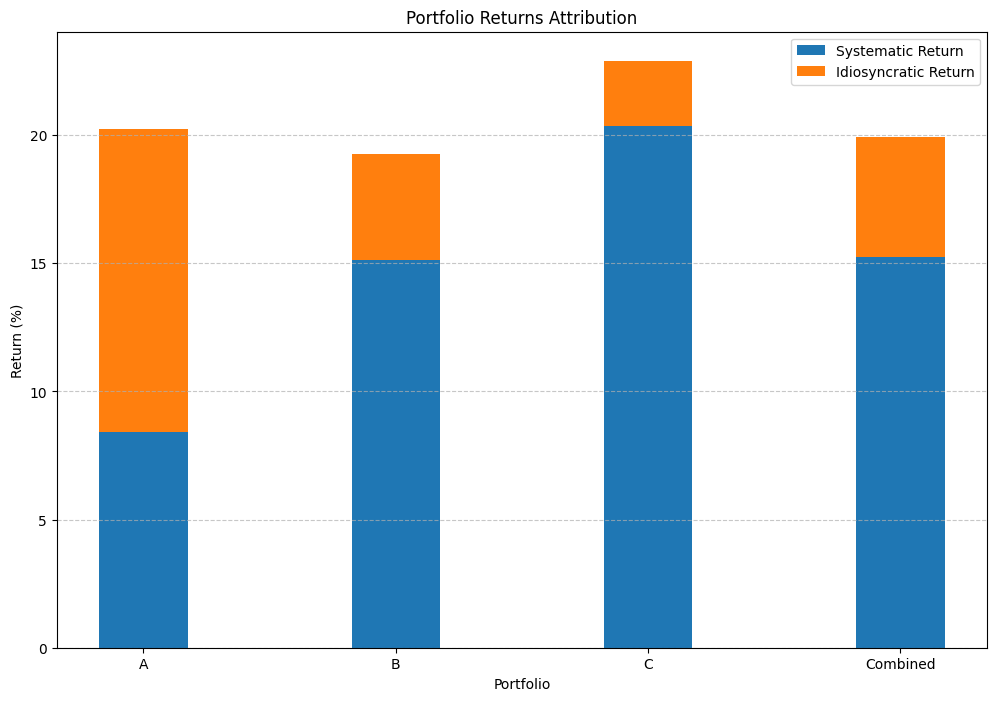

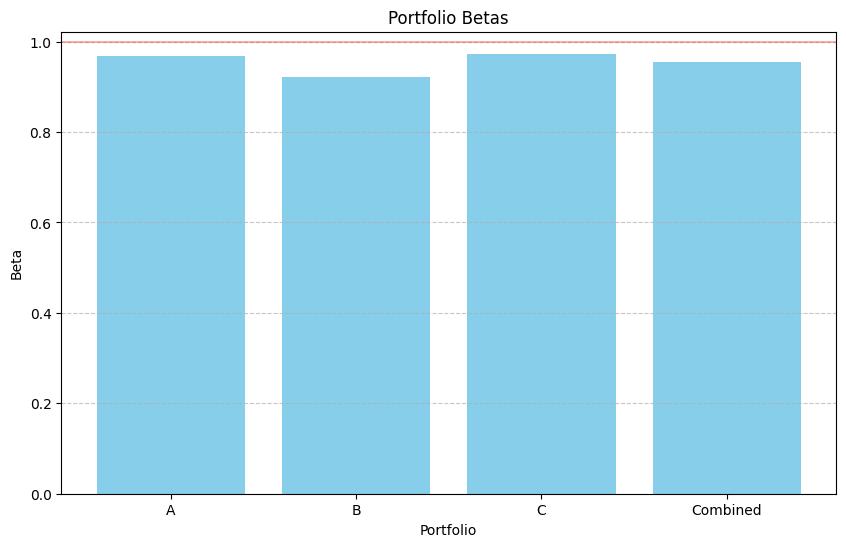


Analysis complete. Visualizations saved to 'portfolio_attribution.png' and 'portfolio_betas.png'

Discussion:
1. Portfolio Performance: The analysis shows how each portfolio performed during the
   holding period, breaking down returns into systematic (market-driven) and
   idiosyncratic (stock-specific) components.

2. Risk Exposure: Portfolio betas indicate the level of market risk, with higher
   betas indicating greater sensitivity to market movements.

3. Return Attribution: The systematic component shows how much return came from
   general market exposure, while the idiosyncratic component shows returns
   specific to the selected stocks.

4. Diversification Effect: The combined portfolio demonstrates how diversification
   across the three portfolios affects overall risk and return characteristics.


In [127]:
# Step 11: Create visualization
plt.figure(figsize=(12, 8))

# Plot returns by component for each portfolio
portfolios_to_plot = [p['Portfolio'] for p in portfolio_summary]
systematic_returns = [p['Systematic Return']*100 for p in portfolio_summary]
idiosyncratic_returns = [p['Idiosyncratic Return']*100 for p in portfolio_summary]

x = range(len(portfolios_to_plot))
width = 0.35

plt.bar(x, systematic_returns, width, label='Systematic Return')
plt.bar(x, idiosyncratic_returns, width, bottom=systematic_returns, label='Idiosyncratic Return')

plt.xlabel('Portfolio')
plt.ylabel('Return (%)')
plt.title('Portfolio Returns Attribution')
plt.xticks(x, portfolios_to_plot)
plt.legend()

plt.grid(axis='y', linestyle='--', alpha=0.7)
# plt.savefig('portfolio_attribution.png')
plt.show()
plt.close()

# Plot portfolio betas
plt.figure(figsize=(10, 6))
plt.bar(portfolios_to_plot, [p['Beta'] for p in portfolio_summary], color='skyblue')
plt.axhline(y=1, color='r', linestyle='-', alpha=0.3)
plt.xlabel('Portfolio')
plt.ylabel('Beta')
plt.title('Portfolio Betas')
plt.grid(axis='y', linestyle='--', alpha=0.7)
# plt.savefig('portfolio_betas.png')
plt.show()
plt.close()

print("\nAnalysis complete. Visualizations saved to 'portfolio_attribution.png' and 'portfolio_betas.png'")
print("\nDiscussion:")
print("="*80)
print("1. Portfolio Performance: The analysis shows how each portfolio performed during the")
print("   holding period, breaking down returns into systematic (market-driven) and")
print("   idiosyncratic (stock-specific) components.")
print()
print("2. Risk Exposure: Portfolio betas indicate the level of market risk, with higher")
print("   betas indicating greater sensitivity to market movements.")
print()
print("3. Return Attribution: The systematic component shows how much return came from")
print("   general market exposure, while the idiosyncratic component shows returns")
print("   specific to the selected stocks.")
print()
print("4. Diversification Effect: The combined portfolio demonstrates how diversification")
print("   across the three portfolios affects overall risk and return characteristics.")

In [133]:
# Verification of RF
calculated_rf = []

for record in result_data:
    total_return = record['Total Return']
    systematic_return = record['Systematic Return']
    idiosyncratic_return = record['Idiosyncratic Return']

    # Calculate RF from the given formula
    rf = total_return - (systematic_return + idiosyncratic_return)
    calculated_rf.append(rf)

# Print the average RF as a sanity check
average_rf = sum(calculated_rf) / len(calculated_rf)

# Print the RF for each portfolio to inspect consistency
print("Calculated RF values for each portfolio:")
for idx, rf in enumerate(calculated_rf):
    print(f"Portfolio {result_data[idx]['Portfolio']} - {result_data[idx]['Symbol']}: RF = {rf}")

print(f"\nAverage RF across all portfolios: {average_rf}")


Calculated RF values for each portfolio:
Portfolio A - WFC: RF = 0.05228538046910636
Portfolio A - ETN: RF = 0.05228538046910636
Portfolio A - AMZN: RF = 0.05228538046910636
Portfolio A - QCOM: RF = 0.05228538046910636
Portfolio A - LMT: RF = 0.05228538046910636
Portfolio A - KO: RF = 0.05228538046910636
Portfolio A - JNJ: RF = 0.05228538046910636
Portfolio A - ISRG: RF = 0.05228538046910636
Portfolio A - XOM: RF = 0.05228538046910636
Portfolio A - MDT: RF = 0.05228538046910636
Portfolio A - DHR: RF = 0.05228538046910636
Portfolio A - PLD: RF = 0.05228538046910636
Portfolio A - BA: RF = 0.05228538046910636
Portfolio A - PG: RF = 0.05228538046910636
Portfolio A - MRK: RF = 0.05228538046910636
Portfolio A - AMD: RF = 0.05228538046910641
Portfolio A - BX: RF = 0.05228538046910636
Portfolio A - PM: RF = 0.05228538046910636
Portfolio A - SCHW: RF = 0.05228538046910636
Portfolio A - VZ: RF = 0.05228538046910636
Portfolio A - COP: RF = 0.05228538046910636
Portfolio A - ADI: RF = 0.05228538046